In [2]:
!nvidia-smi

Sat Dec 12 11:43:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install transformers

     |████████████████████████████████| 1.4MB 13.1MB/s 
     |████████████████████████████████| 890kB 52.0MB/s 
     |████████████████████████████████| 2.9MB 46.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=ab58e92c8f40db0a891157f7357ac0b512c96457737e70d0ec72c1ca5514f38c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [4]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
df_train = pd.read_csv('/content/drive/MyDrive/MLProject/Data/train.csv', encoding='latin1')
df_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [6]:
df_test = pd.read_csv('/content/drive/MyDrive/MLProject/Data/test.csv', encoding='latin1')
df_test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [7]:
print (df_train.shape, df_test.shape)

(41157, 6) (3798, 6)


In [8]:
def sentiment_to_value(sentiment):
  if sentiment == 'Extremely Negative':
    return 0
  if sentiment == 'Negative':
    return 1
  if sentiment == 'Neutral':
    return 2
  if sentiment == 'Positive':
    return 3
  if sentiment == 'Extremely Positive':
    return 4

In [9]:
class_names = ['Extremely Negative','Negative','Neutral','Positive','Extremely Positive']
df_train['Class'] = df_train['Sentiment'].apply(sentiment_to_value)
df_test['Class'] = df_test['Sentiment'].apply(sentiment_to_value)

In [17]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = transformers.BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME) # Casing is important in sentiment analysis.
Max_Length = 160
Batch_Size = 16
Epochs = 20

In [18]:
class CovidTweetDataset(Dataset):

  def __init__ (self, tweet, Class, tokenizer, max_len):
    self.tweet = tweet
    self.Class = Class
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.tweet)

  def __getitem__(self, item):
    tweet = str(self.tweet[item])
    Class = self.Class[item]

    encoding  = tokenizer.encode_plus(
      tweet,
      truncation = True,
      add_special_tokens = True,
      max_length = self.max_len,
      padding = 'max_length',
      return_attention_mask = True,
      return_token_type_ids = False,
      return_tensors = 'pt'
    )

    return {
        'tweet_text' : tweet,
        'input_ids' : encoding['input_ids'].flatten(),
        'attention_mask' : encoding['attention_mask'].flatten(),
        'Class' : torch.tensor(Class, dtype = torch.long)
    }
  

def create_data_loader(df, tokenizer, batch_size, max_len):
  ds = CovidTweetDataset(
      tweet = df['OriginalTweet'].to_numpy(),
      Class = df['Class'].to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )
  return DataLoader(
      ds,
      batch_size = batch_size,
      num_workers = 4,
      shuffle = True
  )

In [19]:
train_data_loader = create_data_loader(df_train, tokenizer, Batch_Size, Max_Length)
test_data_loader = create_data_loader(df_test, tokenizer, Batch_Size, Max_Length)

In [20]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'Class'])

In [21]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

In [22]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [23]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, input_ids, attention_mask):
    output = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask
    )
    output = output.pooler_output
    output = self.drop(output)
    output = self.out(output)
    return self.softmax(output)

In [24]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [25]:
optimizer = AdamW(
    model.parameters(),
    lr = 2e-5,
    correct_bias = False
)

total_steps = len(train_data_loader) * Epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)


In [26]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["Class"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [42]:
model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('/content/drive/MyDrive/MLProject/best_model_state_arya.bin'))
model = model.to(device)

In [43]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

0.8070036861506055

In [44]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["tweet_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["Class"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [45]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [46]:
print(classification_report(y_test, y_pred, target_names=class_names))

                    precision    recall  f1-score   support

Extremely Negative       0.85      0.84      0.84       592
          Negative       0.82      0.78      0.80      1041
           Neutral       0.74      0.89      0.81       619
          Positive       0.79      0.78      0.78       947
Extremely Positive       0.87      0.78      0.82       599

          accuracy                           0.81      3798
         macro avg       0.81      0.81      0.81      3798
      weighted avg       0.81      0.81      0.81      3798



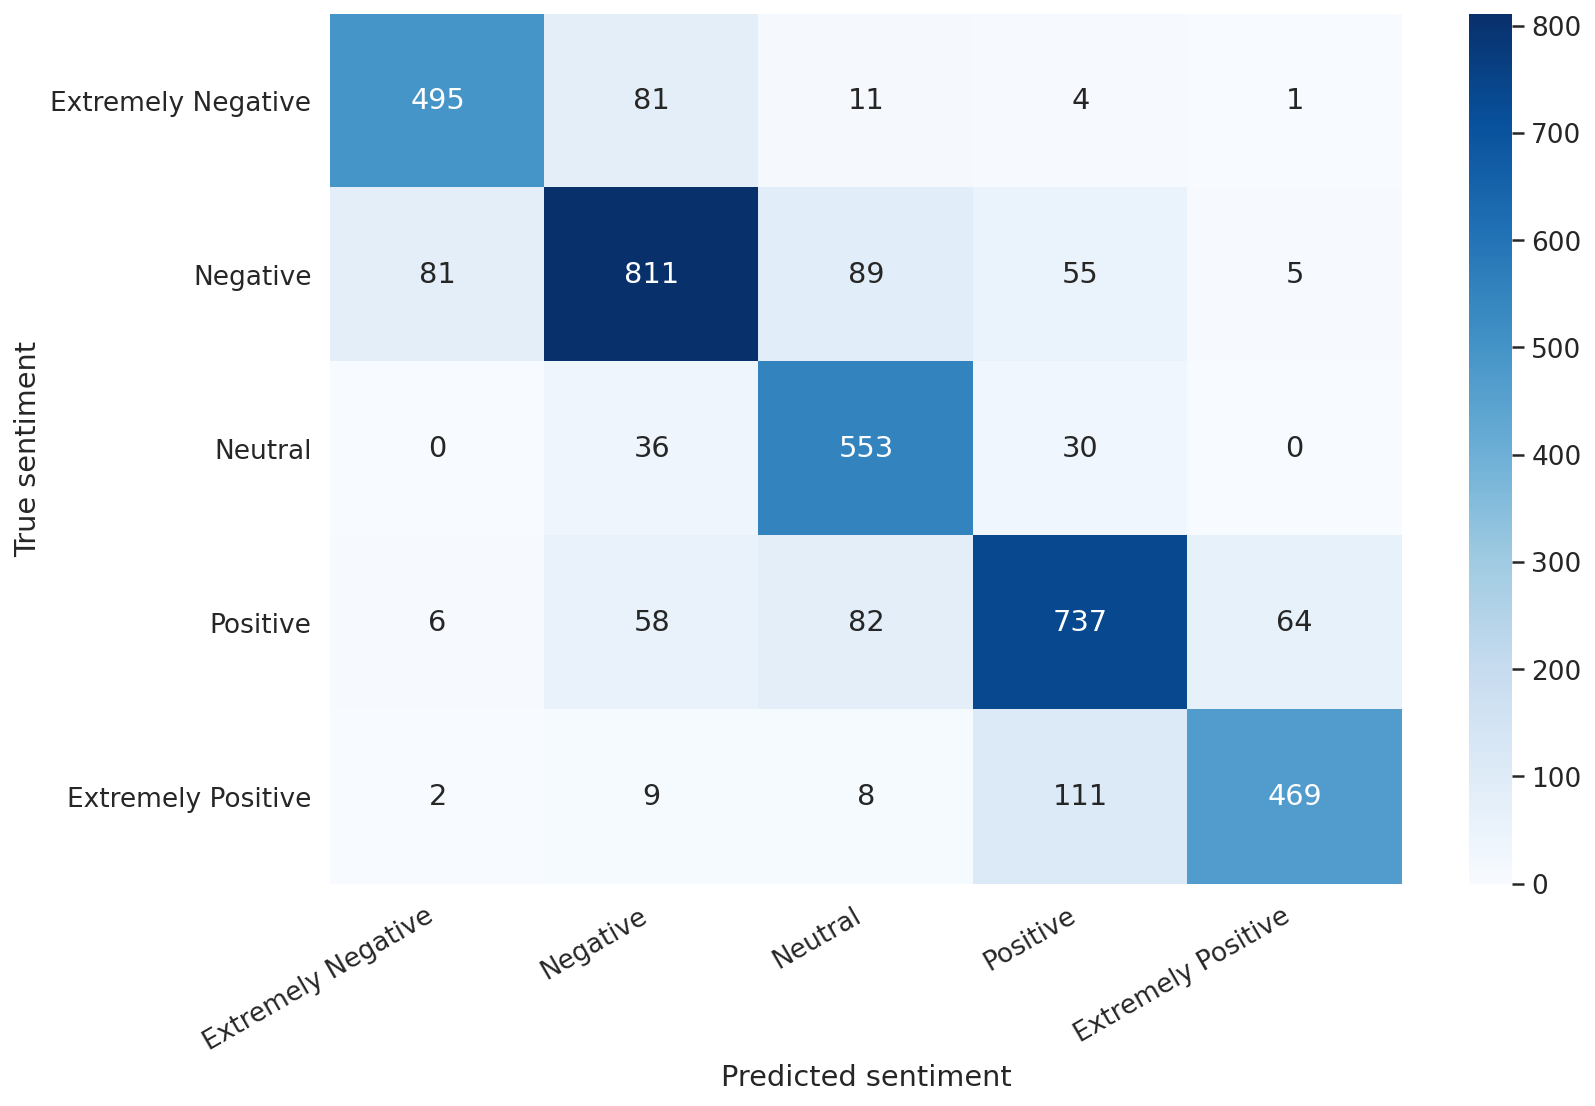

In [47]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [48]:
idx = 456
review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [49]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

Secret Documents Reveal #Coronavirus Could be "Category 5," Intel
Personnel Stock 3 Months of Food https://t.co/2HYUoI3sGL via @YouTube

True sentiment: Neutral


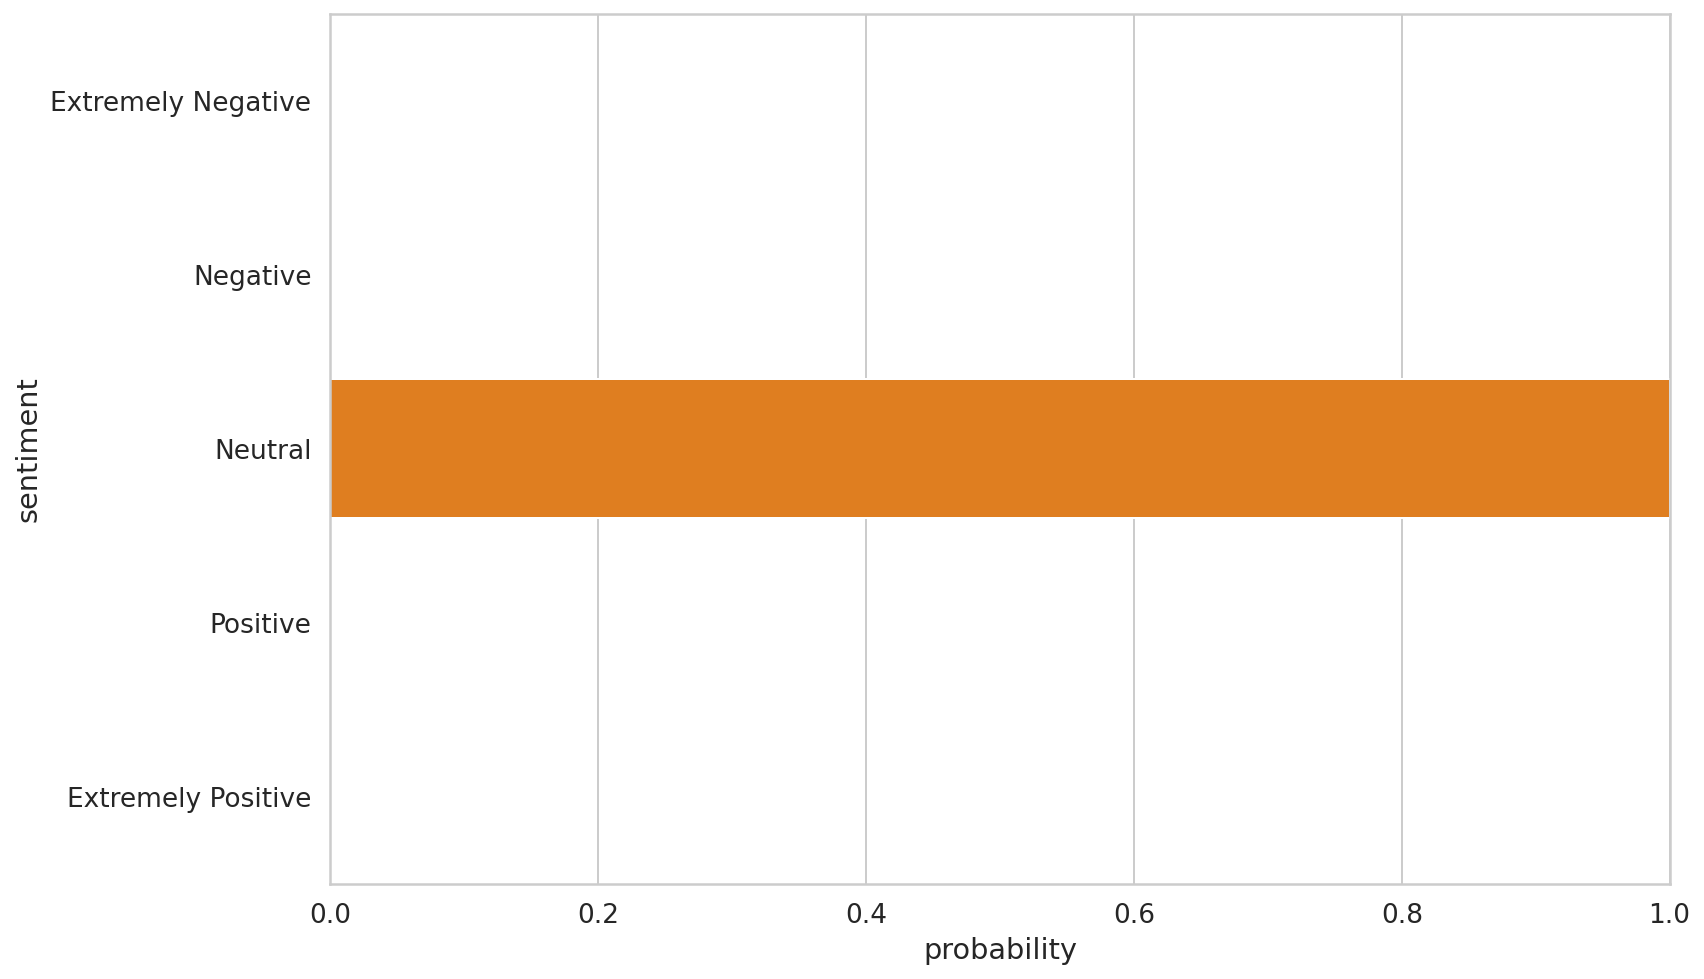

In [50]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [55]:
review_text = "I love ML! Best subject ever!!!"

In [56]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=Max_Length,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [57]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I love ML! Best subject ever!!!
Sentiment  : Extremely Positive
